> Group Assignment - Introduction to Financial Engineering (MAL4330)

> Team members -

1. Riyanshu Jain (B20AI060)
2. Priyank Mandal (B20AI055)
3. Priyanshu Jain (B20CI032)

**Option values selected from** --
https://www.nseindia.com/option-chain

### Libraries

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Load Packages
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

### Pick 3 stocks of your choice from the market and calculate volatility of stocks

In [3]:
df = yf.download(['SBIN.NS', 'AXISBANK.NS', 'BPCL.NS'], start='2022-04-26', end='2023-04-26')
df = df['Close']
df

[*********************100%***********************]  3 of 3 completed


,AXISBANK.NS,BPCL.NS,SBIN.NS
Date,,,
2022-04-26,775.000000,372.850006,505.500000
2022-04-27,765.900024,366.500000,497.250000
2022-04-28,779.799988,369.350006,507.500000
2022-04-29,728.599976,362.600006,496.299988
2022-05-02,727.349976,366.450012,491.000000
...,...,...,...
2023-04-19,873.400024,342.000000,540.299988
2023-04-20,868.750000,343.700012,544.799988
2023-04-21,864.200012,346.200012,543.150024


In [4]:
df.shape

(248, 3)

In [5]:
df['AB_log_returns'] = np.log(df['AXISBANK.NS'] / df['AXISBANK.NS'].shift(1))
df['BPCL_log_returns'] = np.log(df['BPCL.NS'] / df['BPCL.NS'].shift(1))
df['SBI_log_returns'] = np.log(df['SBIN.NS'] / df['SBIN.NS'].shift(1))

sigma_AB = (df['AB_log_returns'].std() * np.sqrt(df.shape[0])).round(4)
sigma_BPCL = (df['BPCL_log_returns'].std() * np.sqrt(df.shape[0])).round(4)
sigma_SBI = (df['SBI_log_returns'].std() * np.sqrt(df.shape[0])).round(4)

print(sigma_AB, sigma_BPCL, sigma_SBI)

0.246 0.235 0.246


### CRR model and Black Scholes Equation

In [6]:
def CRR_Binomial_Model(S, K, r, sigma, T, n, option_type):
    delta_t = T/n
    u = np.exp(sigma*np.sqrt(delta_t))
    d = 1/u
    p = (np.exp(r*delta_t) - d) / (u - d)
    
    stock_price = np.zeros((n+1, n+1))
    option_value = np.zeros((n+1, n+1))
    
    stock_price[0, 0] = S
    
    for i in range(1, n+1):
        stock_price[i, 0] = stock_price[i-1, 0]*u
        for j in range(1, i+1):
            stock_price[i, j] = stock_price[i-1, j-1]*d
            
    if option_type == 'European':
        for j in range(n+1):
            option_value[n][j] = max(0, K - stock_price[n][j])
            
        for i in range(n-1, -1, -1):
            for j in range(i+1):
                option_value[i][j] = np.exp(-r*delta_t)*(p*option_value[i+1][j] + (1-p)*option_value[i+1][j+1])
        
        # print(option_value)
        return option_value[0][0]
    
    elif option_type == 'American':
        for j in range(n+1):
            option_value[n][j] = max(0, K - stock_price[n][j])
            
        for i in range(n-1, -1, -1):
            for j in range(i+1):
                exercise_value = K - stock_price[i][j]
                continue_value = np.exp(-r*delta_t)*(p*option_value[i+1][j] + (1-p)*option_value[i+1][j+1])
                option_value[i][j] = max(exercise_value, continue_value)
        
        # print(option_value)
        return option_value[0][0]


def Black_Scholes_Equation(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call_option = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    put_option = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    return call_option, put_option

## Results of the following -


1.   Use (CRR) Binomial model (2 Steps to 10 Steps) to price the corresponding European put option and American put option with different strike price and expiry date
2.   Use Black Scholes equation to obtain the same
3.   Verify that the Black Scholes formula is limiting case of Binomial model
4.   Use graphs to demonstrate the results

### Bid price with ***expiry time 25 May***, and starting time 25 April

In [7]:
k_ab_1, bid_ab_1, S0_ab_1 = 890.00, 24.50, df.iloc[-1, 0]
k_bpcl_1, bid_bpcl_1, S0_bpcl_1 = 340.00, 2.55, df.iloc[-1, 1]
k_sbi_1, bid_sbi_1, S0_sbi_1 = 570.00, 15.35, df.iloc[-1, 2]

r = 0.05

# num_days = 30
# working_days = 248
# T = num_days/working_days

T_1 = 1/12 # 1 month

Eu_AB_1, Am_AB_1 = [], []
Eu_BPCL_1, Am_BPCL_1 = [], []
Eu_SBI_1, Am_SBI_1 = [], []

for n in range(2, 51):
    Eu_AB_1.append(CRR_Binomial_Model(S0_ab_1, k_ab_1, r, sigma_AB, T_1, n, "European"))
    Eu_BPCL_1.append(CRR_Binomial_Model(S0_bpcl_1, k_bpcl_1, r, sigma_BPCL, T_1, n, "European"))
    Eu_SBI_1.append(CRR_Binomial_Model(S0_sbi_1, k_sbi_1, r, sigma_SBI, T_1, n, "European"))
    
    if (n <= 10):
        print("European Put option price corresponding to n=",n)
        print("1. Axis Bank --> ", Eu_AB_1[-1])
        print("2. BPCL --> ", Eu_BPCL_1[-1])
        print("3. SBI --> ", Eu_SBI_1[-1])
        print()
    
    Am_AB_1.append(CRR_Binomial_Model(S0_ab_1, k_ab_1, r, sigma_AB, T_1, n, "American"))
    Am_BPCL_1.append(CRR_Binomial_Model(S0_bpcl_1, k_bpcl_1, r, sigma_BPCL, T_1, n, "American"))
    Am_SBI_1.append(CRR_Binomial_Model(S0_sbi_1, k_sbi_1, r, sigma_SBI, T_1, n, "American"))

    if (n <= 10):
        print("American Put option price corresponding to n=",n)
        print("1. Axis Bank --> ", Am_AB_1[-1])
        print("2. BPCL --> ", Am_BPCL_1[-1])
        print("3. SBI --> ", Am_SBI_1[-1])
        print()
        print("----------------------------------------------------------------------------------")

European Put option price corresponding to n= 2
1. Axis Bank -->  28.819476187423632
2. BPCL -->  5.813783202250077
3. SBI -->  18.986095423474477

American Put option price corresponding to n= 2
1. Axis Bank -->  29.72849883725855
2. BPCL -->  5.813783202250077
3. SBI -->  19.568278468874375

----------------------------------------------------------------------------------
European Put option price corresponding to n= 3
1. Axis Bank -->  30.834649914358927
2. BPCL -->  5.828962501741853
3. SBI -->  20.087336260671194

American Put option price corresponding to n= 3
1. Axis Bank -->  31.134413332379047
2. BPCL -->  5.94289843939904
3. SBI -->  20.27931957333574

----------------------------------------------------------------------------------
European Put option price corresponding to n= 4
1. Axis Bank -->  29.425860765444707
2. BPCL -->  5.856882487585639
3. SBI -->  19.327001632668516

American Put option price corresponding to n= 4
1. Axis Bank -->  30.105522164701377
2. BPCL --> 

In [8]:
BS_arr_1month = [Black_Scholes_Equation(S0_ab_1, k_ab_1, T_1, r, sigma_AB), 
                 Black_Scholes_Equation(S0_bpcl_1, k_bpcl_1, T_1, r, sigma_BPCL), 
                 Black_Scholes_Equation(S0_sbi_1, k_sbi_1, T_1, r, sigma_SBI)]

print("Put option price from Black Scholes Equation")
print("1. Axis Bank --> ", BS_arr_1month[0][1])
print("2. BPCL --> ", BS_arr_1month[1][1])
print("3. SBI --> ", BS_arr_1month[2][1])

Put option price from Black Scholes Equation
1. Axis Bank -->  29.16694992472111
2. BPCL -->  5.497853705876949
3. SBI -->  19.07894021634769


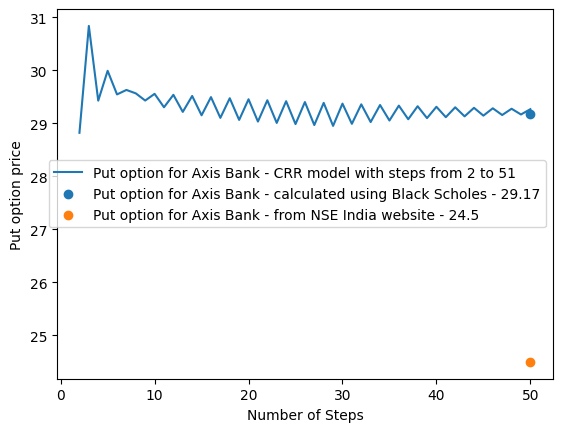

In [9]:
steps = [i for i in range(2, 51)]
plt.plot(steps, Eu_AB_1, label='Put option for Axis Bank - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_1month[0][1], label='Put option for Axis Bank - calculated using Black Scholes - '+str(round(BS_arr_1month[0][1], 2)))
plt.scatter(50, bid_ab_1, label='Put option for Axis Bank - from NSE India website - '+str(round(bid_ab_1, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

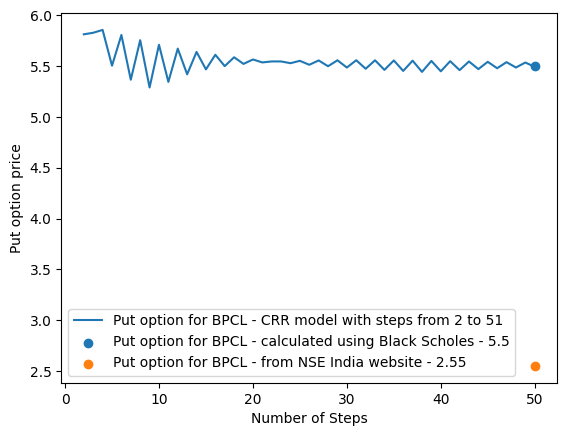

In [10]:
plt.plot(steps, Eu_BPCL_1, label='Put option for BPCL - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_1month[1][1], label='Put option for BPCL - calculated using Black Scholes - '+str(round(BS_arr_1month[1][1], 2)))
plt.scatter(50, bid_bpcl_1, label='Put option for BPCL - from NSE India website - '+str(round(bid_bpcl_1, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

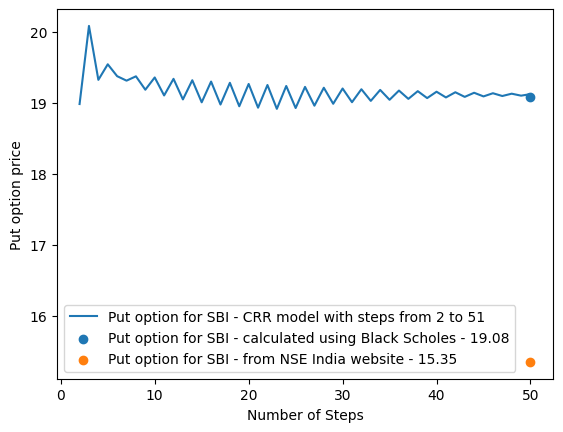

In [11]:
plt.plot(steps, Eu_SBI_1, label='Put option for SBI - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_1month[2][1], label='Put option for SBI - calculated using Black Scholes - '+str(round(BS_arr_1month[2][1], 2)))
plt.scatter(50, bid_sbi_1, label='Put option for SBI - from NSE India website - '+str(round(bid_sbi_1, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

### Bid price with ***expiry time 29 June***, and starting time 25 April

In [12]:
k_ab_2, bid_ab_2, S0_ab_2 = 890.00, 26.60, df.iloc[-1, 0]
k_bpcl_2, bid_bpcl_2, S0_bpcl_2 = 340.00, 4.10, df.iloc[-1, 1]
k_sbi_2, bid_sbi_2, S0_sbi_2 = 570.00, 11.60, df.iloc[-1, 2]

r = 0.05

# num_days = 65
# working_days = 248
# T_2 = num_days/working_days

T_2 = 2/12 # 2 months

Eu_AB_2, Am_AB_2 = [], []
Eu_BPCL_2, Am_BPCL_2 = [], []
Eu_SBI_2, Am_SBI_2 = [], []

for n in range(2, 51):
    Eu_AB_2.append(CRR_Binomial_Model(S0_ab_2, k_ab_2, r, sigma_AB, T_2, n, "European"))
    Eu_BPCL_2.append(CRR_Binomial_Model(S0_bpcl_2, k_bpcl_2, r, sigma_BPCL, T_2, n, "European"))
    Eu_SBI_2.append(CRR_Binomial_Model(S0_sbi_2, k_sbi_2, r, sigma_SBI, T_2, n, "European"))
    
    if (n <= 10):
        print("European Put option price corresponding to n=",n)
        print("1. Axis Bank --> ", Eu_AB_2[-1])
        print("2. BPCL --> ", Eu_BPCL_2[-1])
        print("3. SBI --> ", Eu_SBI_2[-1])
        print()
    
    Am_AB_2.append(CRR_Binomial_Model(S0_ab_2, k_ab_2, r, sigma_AB, T_2, n, "American"))
    Am_BPCL_2.append(CRR_Binomial_Model(S0_bpcl_2, k_bpcl_2, r, sigma_BPCL, T_2, n, "American"))
    Am_SBI_2.append(CRR_Binomial_Model(S0_sbi_2, k_sbi_2, r, sigma_SBI, T_2, n, "American"))

    if (n <= 10):
        print("American Put option price corresponding to n=",n)
        print("1. Axis Bank --> ", Am_AB_2[-1])
        print("2. BPCL --> ", Am_BPCL_2[-1])
        print("3. SBI --> ", Am_SBI_2[-1])
        print()
        print("----------------------------------------------------------------------------------")

European Put option price corresponding to n= 2
1. Axis Bank -->  36.03651266816586
2. BPCL -->  8.57767141987517
3. SBI -->  23.597283232232083

American Put option price corresponding to n= 2
1. Axis Bank -->  37.836278794796925
2. BPCL -->  8.57767141987517
3. SBI -->  24.74994243692839

----------------------------------------------------------------------------------
European Put option price corresponding to n= 3
1. Axis Bank -->  40.07203735129333
2. BPCL -->  9.369630096288684
3. SBI -->  25.991026847647273

American Put option price corresponding to n= 3
1. Axis Bank -->  40.662757943972416
2. BPCL -->  9.593671998776435
3. SBI -->  26.369353519363074

----------------------------------------------------------------------------------
European Put option price corresponding to n= 4
1. Axis Bank -->  37.19658488348111
2. BPCL -->  8.833614850950378
3. SBI -->  24.292398358148134

American Put option price corresponding to n= 4
1. Axis Bank -->  38.54039856142937
2. BPCL -->  8.9

In [13]:
BS_arr_2month = [Black_Scholes_Equation(S0_ab_2, k_ab_2, T_2, r, sigma_AB), 
                 Black_Scholes_Equation(S0_bpcl_2, k_bpcl_2, T_2, r, sigma_BPCL), 
                 Black_Scholes_Equation(S0_sbi_2, k_sbi_2, T_2, r, sigma_SBI)]

print("Put option price from Black Scholes Equation")
print("1. Axis Bank --> ", BS_arr_2month[0][1])
print("2. BPCL --> ", BS_arr_2month[1][1])
print("3. SBI --> ", BS_arr_2month[2][1])

Put option price from Black Scholes Equation
1. Axis Bank -->  37.4350972688805
2. BPCL -->  8.577892051303621
3. SBI -->  24.34600822698451


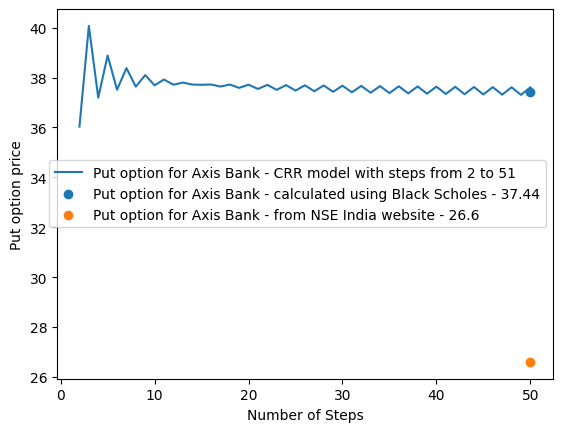

In [14]:
steps = [i for i in range(2, 51)]
plt.plot(steps, Eu_AB_2, label='Put option for Axis Bank - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_2month[0][1], label='Put option for Axis Bank - calculated using Black Scholes - '+str(round(BS_arr_2month[0][1], 2)))
plt.scatter(50, bid_ab_2, label='Put option for Axis Bank - from NSE India website - '+str(round(bid_ab_2, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

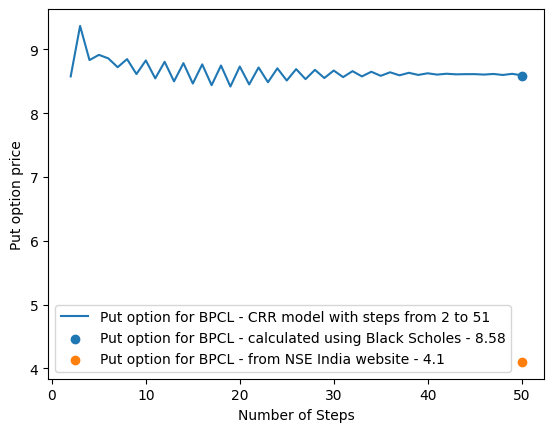

In [15]:
plt.plot(steps, Eu_BPCL_2, label='Put option for BPCL - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_2month[1][1], label='Put option for BPCL - calculated using Black Scholes - '+str(round(BS_arr_2month[1][1], 2)))
plt.scatter(50, bid_bpcl_2, label='Put option for BPCL - from NSE India website - '+str(round(bid_bpcl_2, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

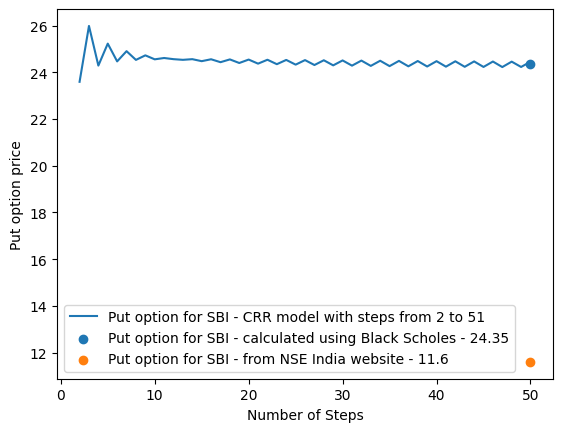

In [16]:
plt.plot(steps, Eu_SBI_2, label='Put option for SBI - CRR model with steps from 2 to 51')
plt.scatter(50, BS_arr_2month[2][1], label='Put option for SBI - calculated using Black Scholes - '+str(round(BS_arr_2month[2][1], 2)))
plt.scatter(50, bid_sbi_2, label='Put option for SBI - from NSE India website - '+str(round(bid_sbi_2, 2)))
# plt.xticks(steps)
plt.xlabel("Number of Steps")
plt.ylabel("Put option price")
plt.legend()
plt.show()

### Comparison of call and put options from Black-scholes and actual data from NSE website

In [17]:
bid_call_AB1, bid_put_AB1 = 22.30, 24.50
bid_call_AB2, bid_put_AB2 = "Not given", 26.60

bid_call_BPCL1, bid_put_BPCL1 = 18.80, 2.55
bid_call_BPCL2, bid_put_BPCL2 = 11.60, 4.10

bid_call_SBI1, bid_put_SBI1 = 11.00, 15.35
bid_call_SBI2, bid_put_SBI2 = 14.45, 11.60

In [18]:
print("Axis Bank - expiry 1 month")
print("Call option from black-scholes:", (BS_arr_1month[0][0]).round(2), ", Call option from NSE:",bid_call_AB1)
print("Put option from black-scholes:", (BS_arr_1month[0][1]).round(2), ", Put option from NSE:",bid_put_AB1)
print("--------------------------------")
print("BPCL - expiry 1 month")
print("Call option from black-scholes:", (BS_arr_1month[1][0]).round(2), ", Call option from NSE:",bid_call_BPCL1)
print("Put option from black-scholes:", (BS_arr_1month[1][1]).round(2), ", Put option from NSE:",bid_put_BPCL1)
print("--------------------------------")
print("SBI - expiry 1 month")
print("Call option from black-scholes:", (BS_arr_1month[2][0]).round(2), ", Call option from NSE:",bid_call_SBI1)
print("Put option from black-scholes:", (BS_arr_1month[2][1]).round(2), ", Put option from NSE:",bid_put_SBI1)

Axis Bank - expiry 1 month
Call option from black-scholes: 21.22 , Call option from NSE: 22.3
Put option from black-scholes: 29.17 , Put option from NSE: 24.5
--------------------------------
BPCL - expiry 1 month
Call option from black-scholes: 14.41 , Call option from NSE: 18.8
Put option from black-scholes: 5.5 , Put option from NSE: 2.55
--------------------------------
SBI - expiry 1 month
Call option from black-scholes: 13.25 , Call option from NSE: 11.0
Put option from black-scholes: 19.08 , Put option from NSE: 15.35


In [19]:
print("Axis Bank - expiry 2 month")
print("Call option from black-scholes:", (BS_arr_2month[0][0]).round(2), ", Call option from NSE:",bid_call_AB2)
print("Put option from black-scholes:", (BS_arr_2month[0][1]).round(2), ", Put option from NSE:",bid_put_AB2)
print("--------------------------------")
print("BPCL - expiry 2 month")
print("Call option from black-scholes:", (BS_arr_2month[1][0]).round(2), ", Call option from NSE:",bid_call_BPCL2)
print("Put option from black-scholes:", (BS_arr_2month[1][1]).round(2), ", Put option from NSE:",bid_put_BPCL2)
print("--------------------------------")
print("SBI - expiry 2 month")
print("Call option from black-scholes:", (BS_arr_2month[2][0]).round(2), ", Call option from NSE:",bid_call_SBI2)
print("Put option from black-scholes:", (BS_arr_2month[2][1]).round(2), ", Put option from NSE:",bid_put_SBI2)

Axis Bank - expiry 2 month
Call option from black-scholes: 33.17 , Call option from NSE: Not given
Put option from black-scholes: 37.44 , Put option from NSE: 26.6
--------------------------------
BPCL - expiry 2 month
Call option from black-scholes: 18.9 , Call option from NSE: 11.6
Put option from black-scholes: 8.58 , Put option from NSE: 4.1
--------------------------------
SBI - expiry 2 month
Call option from black-scholes: 20.88 , Call option from NSE: 14.45
Put option from black-scholes: 24.35 , Put option from NSE: 11.6


## Obtain the self-financing strategy (Value of Delta every week), use implied volatility.

In [20]:
def Delta_hedge(S, K, r, sigma, T, n, option_type):
    delta_t = T/n
    u = np.exp(sigma*np.sqrt(delta_t))
    d = 1/u
    p = (np.exp(r*delta_t) - d) / (u - d)
    
    stock_price = np.zeros((n+1, n+1))
    option_value = np.zeros((n+1, n+1))
    
    stock_price[0, 0] = S
    
    for i in range(1, n+1):
        stock_price[i, 0] = stock_price[i-1, 0]*u
        for j in range(1, i+1):
            stock_price[i, j] = stock_price[i-1, j-1]*d
            
    if option_type == 'European':
        for j in range(n+1):
            option_value[n][j] = max(0, K - stock_price[n][j])
            
        for i in range(n-1, -1, -1):
            for j in range(i+1):
                option_value[i][j] = np.exp(-r*delta_t)*(p*option_value[i+1][j] + (1-p)*option_value[i+1][j+1])
        
    
    elif option_type == 'American':
        for j in range(n+1):
            option_value[n][j] = max(0, K - stock_price[n][j])
            
        for i in range(n-1, -1, -1):
            for j in range(i+1):
                exercise_value = K - stock_price[i][j]
                continue_value = np.exp(-r*delta_t)*(p*option_value[i+1][j] + (1-p)*option_value[i+1][j+1])
                option_value[i][j] = max(exercise_value, continue_value)
    delts = ["Δ(0)","Δ(d)","Δ(u)","Δ(d,d)","Δ(u,d)","Δ(u,u)","Δ(d,d,d)","Δ(d,u,d)","Δ(u,d,u)","Δ(u,u,u)"]  
    print('OPTION SELECTED :',option_type)
    po = 0
    wk = 1
    ele = 2
    for i in range(4):
      st = "WEEK - " + str(wk) + " : "
      c = option_value[wk]
      s = stock_price[wk]
      for j in range(ele - 1):
          delt = np.round(-1*(c[j + 1] - c[j])/(s[j + 1] - s[j]),4)
          st += delts[po] + " = " + str(delt)
          po += 1
          if j != ele - 2:
            st += ', '
      wk += 1
      ele += 1
      print(st)
          

In [21]:
T = 1/12 # time period of a month
n = 4 # 4 step model for the 4 week strategy

In [22]:
print("Self Financing Strategy for 4 weeks of the stock - AXISBANK.NS :\n")
Delta_hedge(S0_ab_1, k_ab_1, r, sigma_AB, T, n, "European")
print('\n')
Delta_hedge(S0_ab_1, k_ab_1, r, sigma_AB, T, n, "American")

Self Financing Strategy for 4 weeks of the stock - AXISBANK.NS :

OPTION SELECTED : European
WEEK - 1 : Δ(0) = 0.5353
WEEK - 2 : Δ(d) = 0.3169, Δ(u) = 0.7753
WEEK - 3 : Δ(d,d) = 0.0859, Δ(u,d) = 0.5708, Δ(u,u) = 1.0
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.1802, Δ(u,d,u) = 1.0, Δ(u,u,u) = 1.0


OPTION SELECTED : American
WEEK - 1 : Δ(0) = 0.5501
WEEK - 2 : Δ(d) = 0.324, Δ(u) = 0.7985
WEEK - 3 : Δ(d,d) = 0.0859, Δ(u,d) = 0.5857, Δ(u,u) = 1.0
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.1802, Δ(u,d,u) = 1.0, Δ(u,u,u) = 1.0


In [23]:
print("Self Financing Strategy for 4 weeks of the stock - BPCL.NS :\n")
Delta_hedge(S0_bpcl_1, k_bpcl_1, r, sigma_BPCL, T, n, "European")
print('\n')
Delta_hedge(S0_bpcl_1, k_bpcl_1, r, sigma_BPCL, T, n, "American")

Self Financing Strategy for 4 weeks of the stock - BPCL.NS :

OPTION SELECTED : European
WEEK - 1 : Δ(0) = 0.347
WEEK - 2 : Δ(d) = 0.1521, Δ(u) = 0.5615
WEEK - 3 : Δ(d,d) = 0.0, Δ(u,d) = 0.3195, Δ(u,u) = 0.8276
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.0, Δ(u,d,u) = 0.6709, Δ(u,u,u) = 1.0


OPTION SELECTED : American
WEEK - 1 : Δ(0) = 0.3507
WEEK - 2 : Δ(d) = 0.1521, Δ(u) = 0.5691
WEEK - 3 : Δ(d,d) = 0.0, Δ(u,d) = 0.3195, Δ(u,u) = 0.8437
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.0, Δ(u,d,u) = 0.6709, Δ(u,u,u) = 1.0


In [24]:
print("Self Financing Strategy for 4 weeks of the stock - SBIN.NS :\n")
Delta_hedge(S0_sbi_1, k_sbi_1, r, sigma_SBI, T, n, "European")
print('\n')
Delta_hedge(S0_sbi_1, k_sbi_1, r, sigma_SBI, T, n, "American")

Self Financing Strategy for 4 weeks of the stock - SBIN.NS :

OPTION SELECTED : European
WEEK - 1 : Δ(0) = 0.5424
WEEK - 2 : Δ(d) = 0.326, Δ(u) = 0.7803
WEEK - 3 : Δ(d,d) = 0.0945, Δ(u,d) = 0.5803, Δ(u,u) = 1.0
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.1983, Δ(u,d,u) = 1.0, Δ(u,u,u) = 1.0


OPTION SELECTED : American
WEEK - 1 : Δ(0) = 0.5572
WEEK - 2 : Δ(d) = 0.333, Δ(u) = 0.8035
WEEK - 3 : Δ(d,d) = 0.0945, Δ(u,d) = 0.5952, Δ(u,u) = 1.0
WEEK - 4 : Δ(d,d,d) = 0.0, Δ(d,u,d) = 0.1983, Δ(u,d,u) = 1.0, Δ(u,u,u) = 1.0


## Attempt at proper Implied volatility calculation

In [25]:
def implied_volatility(c_market, S, K, T, r, _sigma):

    one_cent = 0.001
    step = 0.0001

    for i in range(10000):
        call, put = Black_Scholes_Equation(S, K, T, r, _sigma)
        diff = c_market - put

        if diff > one_cent:
            _sigma = _sigma + step

        elif diff < 0 and abs(diff) > one_cent:
            _sigma = _sigma - step

        elif abs(diff) < one_cent:
            return _sigma*100

    return _sigma*100

actual_iv_ab1 = 25.07
actual_iv_bpcl1 = 22.79
actual_iv_sbi1 = 24.26
print("Calculated implied volatility for Axis Bank 1 month expiry put option:", (implied_volatility(bid_ab_1, S0_ab_1, k_ab_1, T_1, r, sigma_AB)).round(2))
print("Actual implied volatility for Axis Bank 1 month expiry put option (from NSE website):", actual_iv_ab1)
print()
print("Calculated implied volatility for BPCL 1 month expiry put option:", (implied_volatility(bid_bpcl_1, S0_bpcl_1, k_bpcl_1, T_1, r, sigma_BPCL)).round(2))
print("Actual implied volatility for BPCL 1 month expiry put option (from NSE website):", actual_iv_bpcl1)
print()
print("Calculated implied volatility for SBI 1 month expiry put option:", (implied_volatility(bid_sbi_1, S0_sbi_1, k_sbi_1, T_1, r, sigma_SBI)).round(2))
print("Actual implied volatility for SBI 1 month expiry put option (from NSE website):", actual_iv_sbi1)

Calculated implied volatility for Axis Bank 1 month expiry put option: 19.96
Actual implied volatility for Axis Bank 1 month expiry put option (from NSE website): 25.07

Calculated implied volatility for BPCL 1 month expiry put option: 15.14
Actual implied volatility for BPCL 1 month expiry put option (from NSE website): 22.79

Calculated implied volatility for SBI 1 month expiry put option: 18.78
Actual implied volatility for SBI 1 month expiry put option (from NSE website): 24.26


This code simulates 

> self-financing strategy, weekly trading for 4 weeks

> periodically adjusting the delta values based on changes in S(t) using N(D1)





In [26]:
def delta(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def self_financing_strategy(S, K, T, r, sigma):
    print("S({}) = {}".format(0, (S).round(2)))
    delta_t = 1/48 # value of delta every week
    delta_0 = delta(S, K, T, r, sigma)
    portfolio_value = S * delta_0
    for i in range(1, 5):
        print("S({}) = ".format(i), end='')
        S_i = S * np.exp((r - 0.5 * sigma ** 2) * delta_t + sigma * np.sqrt(delta_t) * np.random.normal())
        delta_i = delta(S_i, K, T - i*delta_t, r, sigma)
        print(((delta_i - delta_0) * S_i + portfolio_value).round(2))
        delta_0 = delta_i

print("Self financing strategy for 4 weeks - Axis Bank:")
self_financing_strategy(S0_ab_1, k_ab_1, T_1, r, actual_iv_ab1)
print()

print("Self financing strategy for 4 weeks - BPCL:")
self_financing_strategy(S0_bpcl_1, k_bpcl_1, T_1, r, actual_iv_bpcl1)
print()

print("Self financing strategy for 4 weeks - SBI:")
self_financing_strategy(S0_sbi_1, k_sbi_1, T_1, r, actual_iv_sbi1)

Self financing strategy for 4 weeks - Axis Bank:
S(0) = 878.35
S(1) = 878.2
S(2) = 878.16
S(3) = 878.04
S(4) = 877.29

Self financing strategy for 4 weeks - BPCL:
S(0) = 347.5
S(1) = 347.32
S(2) = 347.34
S(3) = 350.71
S(4) = 347.25

Self financing strategy for 4 weeks - SBI:
S(0) = 561.8
S(1) = 561.66
S(2) = 561.67
S(3) = 595.42
S(4) = 561.61


<ipython-input-26-a7034f279d4c>:2: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
